# Calibration

## Notebook setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_path = "data/calibrationData_2024-04-29T12-56-12Z.csv"

In [7]:
df = pd.read_csv(data_path)

# Clean up the column names that seem to have leading spaces
df.columns = df.columns.str.strip()

In [5]:
display(df.head(5))

,username,deviceName,position,distance,timestamp,targetPointX,targetPointY,gazePointX,gazePointY,faceTransform_0_x,...,leftEyeTransform_1_z,leftEyeTransform_1_w,leftEyeTransform_2_x,leftEyeTransform_2_y,leftEyeTransform_2_z,leftEyeTransform_2_w,leftEyeTransform_3_x,leftEyeTransform_3_y,leftEyeTransform_3_z,leftEyeTransform_3_w
0,victor,iPad Mini 6th,Middle,Regular,1.714394e+09,0.0,0.0,83.689627,256.625225,0.997560,...,0.234776,0.0,-0.130597,-0.232765,0.963724,0.0,0.031385,0.030332,0.025511,1.0
1,victor,iPad Mini 6th,Middle,Regular,1.714394e+09,0.0,0.0,84.011670,257.318690,0.997568,...,0.234554,0.0,-0.130562,-0.232547,0.963782,0.0,0.031385,0.030332,0.025511,1.0
2,victor,iPad Mini 6th,Middle,Regular,1.714394e+09,0.0,0.0,84.111527,257.091938,0.997556,...,0.234541,0.0,-0.130431,-0.232537,0.963802,0.0,0.031385,0.030332,0.025511,1.0
3,victor,iPad Mini 6th,Middle,Regular,1.714394e+09,0.0,0.0,84.108718,257.297939,0.997559,...,0.234492,0.0,-0.130513,-0.232487,0.963803,0.0,0.031385,0.030332,0.025511,1.0
4,victor,iPad Mini 6th,Middle,Regular,1.714394e+09,0.0,0.0,83.881667,257.637326,0.997553,...,0.234348,0.0,-0.130575,-0.232342,0.963830,0.0,0.031385,0.030332,0.025511,1.0


/tmp/ipykernel_37727/2156912773.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_targets))  # 'tab10' provides 10 distinct colors


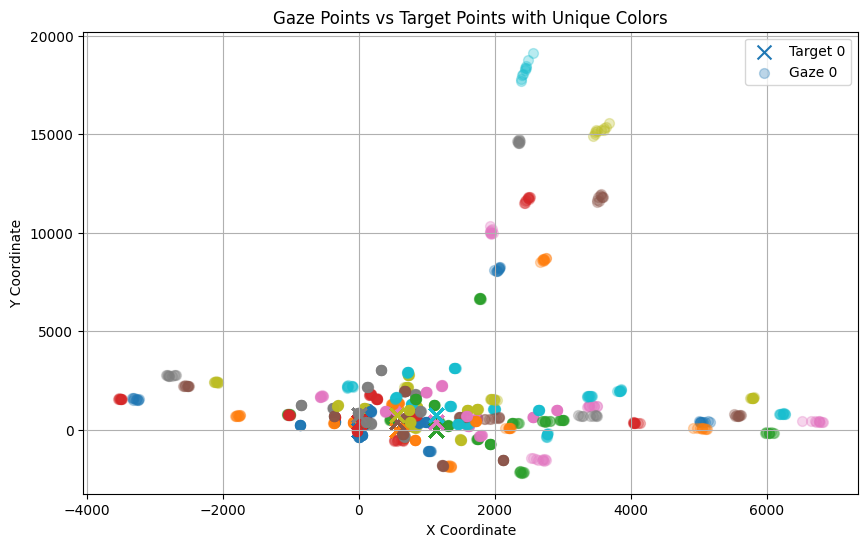

In [12]:
# For each line, we have a targetPointX, targetPointY (which is what we aim for)
# and gazePointX, gazePointY (which is where the user is looking at)
# I want to plot all the target points and all the gaze points on the same plot
# to see how well the user is doing

# Identify unique target points and assign colors
unique_targets = (
    df[["targetPointX", "targetPointY"]].drop_duplicates().reset_index(drop=True)
)
colors = plt.cm.get_cmap(
    "tab10", len(unique_targets)
)  # 'tab10' provides 10 distinct colors

# Create a color dictionary for each target point
color_dict = {tuple(row): colors(i) for i, row in enumerate(unique_targets.to_numpy())}

# Plotting the data
plt.figure(figsize=(10, 6))

# Plot each target and corresponding gaze points with the same color
for idx, row in df.iterrows():
    target = (row["targetPointX"], row["targetPointY"])
    plt.scatter(
        row["targetPointX"],
        row["targetPointY"],
        color=color_dict[target],
        label=f"Target {idx}" if idx == 0 else "",
        s=100,
        marker="x",
    )
    plt.scatter(
        row["gazePointX"],
        row["gazePointY"],
        color=color_dict[target],
        alpha=0.3,
        label=f"Gaze {idx}" if idx == 0 else "",
        s=50,
        marker="o",
    )

# Adding labels and title
plt.title("Gaze Points vs Target Points with Unique Colors")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()

plt.grid(True)
plt.show()

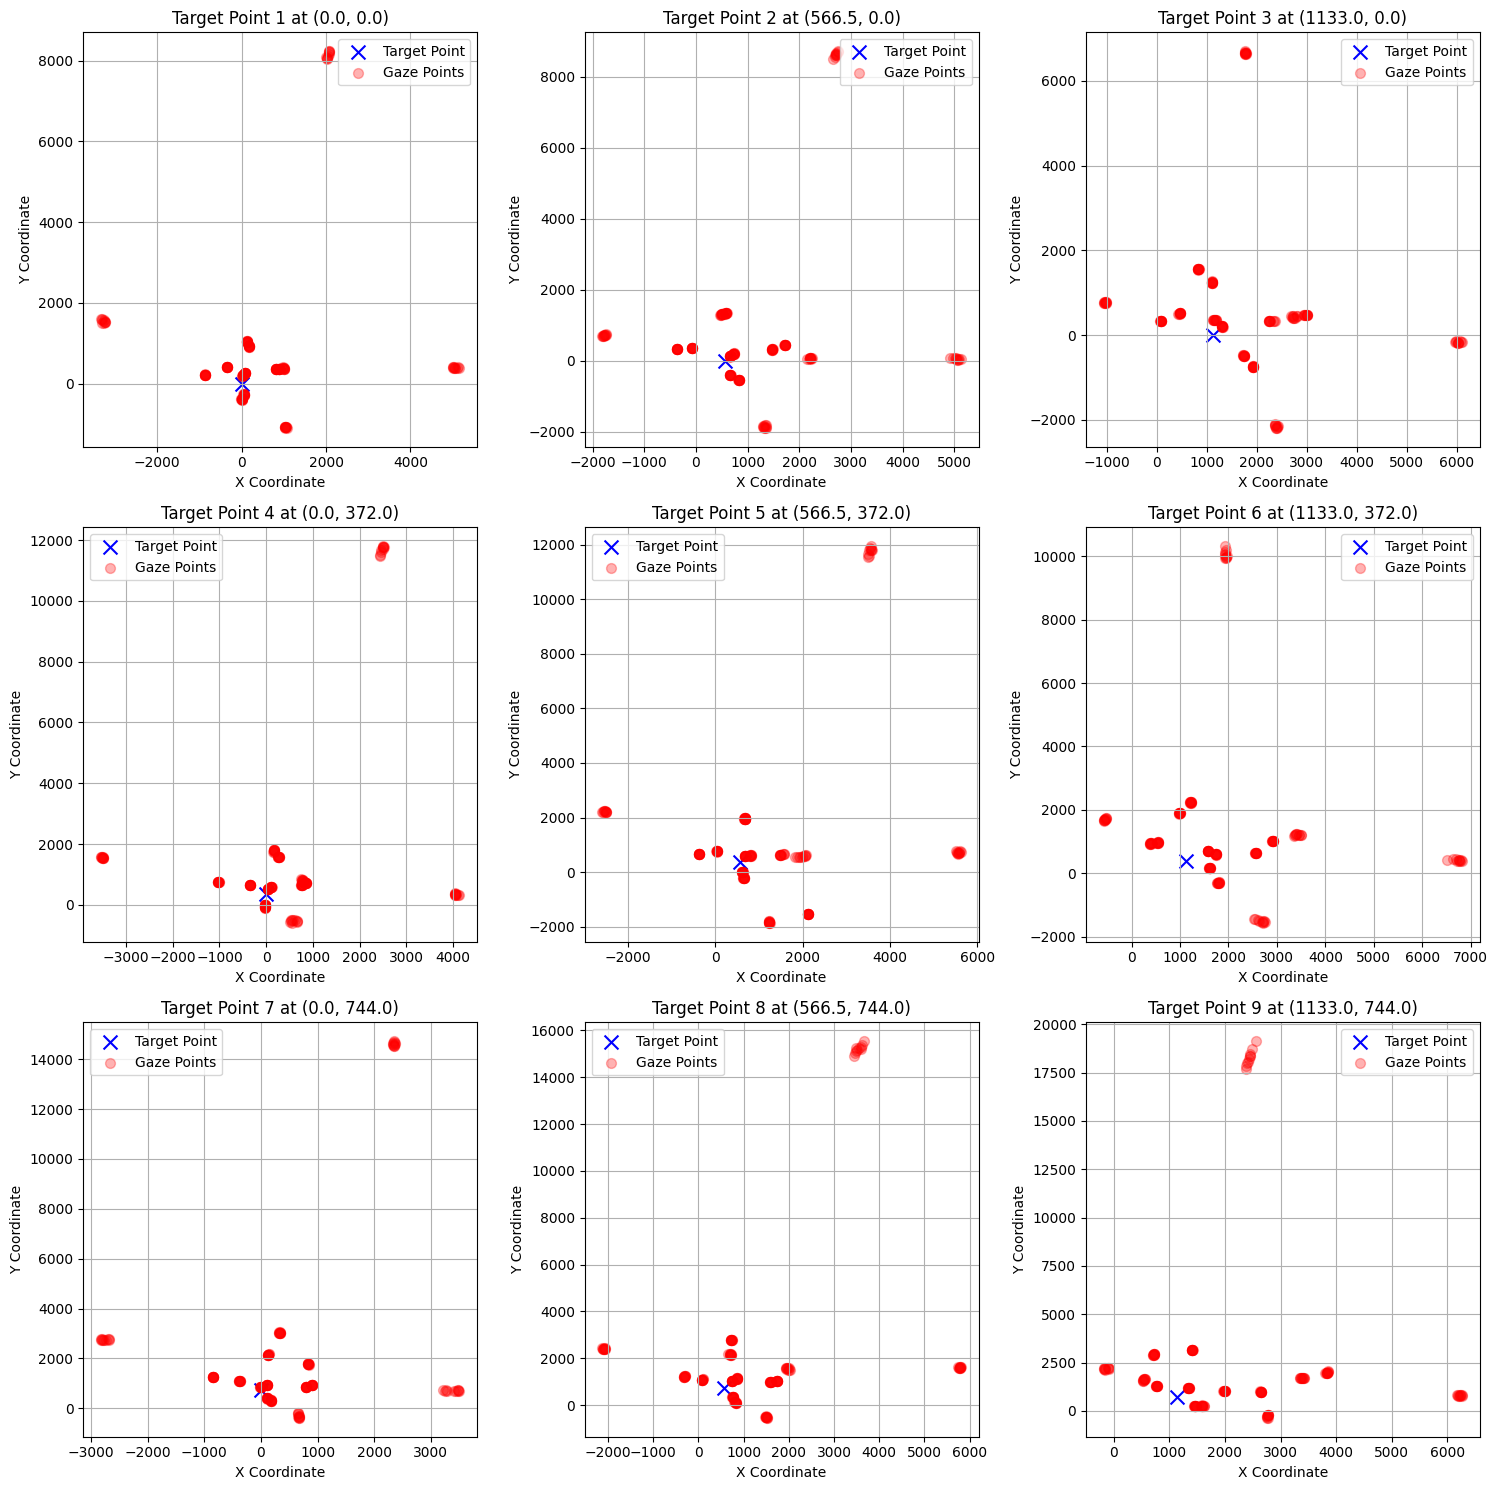

In [14]:
# Define the number of rows and columns for the subplot grid
n_rows = 3
n_cols = 3

# Create a figure and a set of subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))

# Flatten the axis array for easier iteration
axs = axs.flatten()

# Plot each target and corresponding gaze points on a separate subplot
for idx, (ax, (x, y)) in enumerate(zip(axs, unique_targets.to_numpy())):
    # Filter data for the current target point
    current_data = df[(df["targetPointX"] == x) & (df["targetPointY"] == y)]

    # Plot target point
    ax.scatter(x, y, color="blue", label="Target Point", s=100, marker="x")

    # Plot all corresponding gaze points
    ax.scatter(
        current_data["gazePointX"],
        current_data["gazePointY"],
        color="red",
        alpha=0.3,
        label="Gaze Points",
        s=50,
        marker="o",
    )

    # Set titles and labels
    ax.set_title(f"Target Point {idx+1} at ({x}, {y})")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.legend()
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()